A Structured Output Agent in LangChain (or other LLM frameworks) refers to an agent that produces responses in a specific structured format, such as JSON, dictionaries, or other structured data types. These agents are particularly useful when you want to ensure that your responses conform to a defined schema, making it easier to parse, validate, and utilize in downstream applications.

Why Use a Structured Output Agent?
Controlled Responses: Ensures that the outputs follow a specific format, reducing ambiguity.
Data Validation: Useful when you want the model output to fit predefined structures, like for APIs or database entries.
Automation: Makes integration with systems like dashboards, ETL pipelines, or business workflows easier.

In [8]:
import os
from dotenv import load_dotenv
from datetime import datetime

load_dotenv()

os.environ["GOOGLE_API_KEY"] = os.getenv("GEMINI_API_KEY")

from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash-exp")

In [9]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from pydantic import BaseModel, Field
from langgraph.graph import MessagesState,StateGraph, END
from langgraph.prebuilt import ToolNode
from langchain_core.messages import HumanMessage

In [10]:
tavily_tool = TavilySearchResults()

@tool
def get_city_details(prompt:str):
    "Should do a web search to find the required city details"
    print("test")
    response = tavily_tool.invoke(prompt)
    return response

tools = [get_city_details]

model_with_tools = llm.bind_tools(tools)

The BaseModel class is a core component of Pydantic, which is used extensively in Python applications for data validation, type checking, and parsing. It's particularly useful when working with APIs, web frameworks like FastAPI, and other scenarios where you need to enforce data structure and ensure data integrity.
Here's an overview of the BaseModel class, along with some examples to demonstrate how you can use it effectively.

This code defines a Pydantic model called CityDetails using the BaseModel class. Let's break it down:
Explanation:

Class Definition:

CityDetails inherits from BaseModel, making it a data validation model.

Fields with Type Annotations:

state_name: A string representing the state name of a city.

state_capital: A string representing the capital of that state.

country_name: A string representing the country name where the city is located.

country_capital: A string representing the capital of that country.

Field Descriptions:

Each field uses Field() to provide a description that helps clarify what information each attribute represents.
Purpose:
The model validates and structures data related to cities.
Useful for ensuring that any data related to cities has the correct structure before processing.
Helpful in APIs (like FastAPI) to generate self-documenting endpoints.

In [11]:
class CityDetails(BaseModel):
    """Respond to the user with this"""
    state_name: str = Field(description="State name of the city")
    state_capital: str = Field(description="State capital of the city")
    country_name: str = Field(description="Country name of the city")
    country_capital: str = Field(description="Country capital of the city")

In [12]:
# Inherit 'messages' key from MessagesState, which is a list of chat messages
class AgentState(MessagesState):
    # Final structured response from the agent
    final_response: CityDetails

In [ ]:
model_with_structured_output = llm.with_structured_output(CityDetails)


def call_model(state: MessagesState):
    print(f" this is 01 input from call model {state}")
    messages = state['messages']
    response = model_with_tools.invoke(messages)
    print(f"this is 02 response from call model  {response}")
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


def should_continue(state: AgentState):
    messages = state["messages"]
    last_message = messages[-1]
    
    # If there is no function call, then we respond to the user
    if not last_message.tool_calls:
        return "respond"
    # Otherwise if there is, we continue with the tool
    else:
        return "continue"
    

def respond(state: AgentState):
    print(f"here is 03 state from respond {state}")
    response = model_with_structured_output.invoke([HumanMessage(content=state['messages'][-1].content)])
    # We return the final answer
    print(f"this is 04 response from respond{response}")
    return {"final_response": response}    

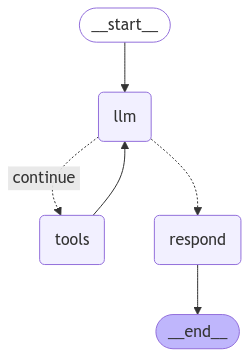

In [15]:
# Define a new graph
workflow = StateGraph(AgentState)

# Define the two nodes we will cycle between
workflow.add_node("llm", call_model)
workflow.add_node("tools", ToolNode(tools))
workflow.add_node("respond", respond)


# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.set_entry_point("llm")

# We now add a conditional edge
workflow.add_conditional_edges(
    "llm",
    
    should_continue,
    {
        "continue": "tools",
        "respond": "respond",
    },
)

workflow.add_edge("tools", "llm")
workflow.add_edge("respond", END)
graph = workflow.compile()

from IPython.display import Image, display
# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [18]:
answer = graph.invoke(input={"messages": [("human", "Tell me about the city details for gwalior?")]})['final_response']

 this is 01 input from call model {'messages': [HumanMessage(content='Tell me about the city details for gwalior?', additional_kwargs={}, response_metadata={}, id='e3fb59ef-3ae5-444d-a19e-723c89272fff')]}
this is 02 response from call model  content='' additional_kwargs={'function_call': {'name': 'get_city_details', 'arguments': '{"prompt": "city details for gwalior"}'}} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []} id='run-27ba0668-0d76-4615-8294-ce12985df62f-0' tool_calls=[{'name': 'get_city_details', 'args': {'prompt': 'city details for gwalior'}, 'id': 'fd710810-3d23-40be-b9a0-5cb600d95505', 'type': 'tool_call'}] usage_metadata={'input_tokens': 29, 'output_tokens': 12, 'total_tokens': 41, 'input_token_details': {'cache_read': 0}}
test
 this is 01 input from call model {'messages': [HumanMessage(content='Tell me about the city details for gwalior?', additional_kwargs={}, response_metadata={}, id='e3fb5

In [19]:
answer

CityDetails(state_name='Madhya Pradesh', state_capital='Bhopal', country_name='India', country_capital='Delhi')

In [17]:
answer = graph.invoke(input={"messages": [("human", "how are you?")]})['final_response']

 this is 01 input from call model {'messages': [HumanMessage(content='how are you?', additional_kwargs={}, response_metadata={}, id='7204ad62-76ed-4168-9dbe-3b97391daa33')]}
this is 02 response from call model  content='I am doing well, thank you for asking. How can I help you today?' additional_kwargs={} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []} id='run-a161a70d-6b57-47e7-9d23-410103bc5ebc-0' usage_metadata={'input_tokens': 22, 'output_tokens': 18, 'total_tokens': 40, 'input_token_details': {'cache_read': 0}}
here is 03 state from respond {'messages': [HumanMessage(content='how are you?', additional_kwargs={}, response_metadata={}, id='7204ad62-76ed-4168-9dbe-3b97391daa33'), AIMessage(content='I am doing well, thank you for asking. How can I help you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings